<a href="https://colab.research.google.com/github/Haadi-kp/Image_Colourization/blob/main/Colab_Notebooks/Copy_of_Coloring_Lab_method_28_12_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Create the destination folder if it doesn't exist
!mkdir -p /content/datas



In [ ]:

# Unzip files into the 'datas' folder
!unzip /content/drive/MyDrive/image_colouring/Places365.zip -d /content/datas


Streaming output truncated to the last 5000 lines.
  inflating: /content/datas/stage-indoor/Places365_val_00000779.jpg  
  inflating: /content/datas/stage-indoor/Places365_val_00001098.jpg  
  inflating: /content/datas/stage-indoor/Places365_val_00001251.jpg  
  inflating: /content/datas/stage-indoor/Places365_val_00001327.jpg  
  inflating: /content/datas/stage-indoor/Places365_val_00002052.jpg  
  inflating: /content/datas/stage-indoor/Places365_val_00002158.jpg  
  inflating: /content/datas/stage-indoor/Places365_val_00002574.jpg  
  inflating: /content/datas/stage-indoor/Places365_val_00003094.jpg  
  inflating: /content/datas/stage-indoor/Places365_val_00003171.jpg  
  inflating: /content/datas/stage-indoor/Places365_val_00005187.jpg  
  inflating: /content/datas/stage-indoor/Places365_val_00005920.jpg  
  inflating: /content/datas/stage-indoor/Places365_val_00006640.jpg  
  inflating: /content/datas/stage-indoor/Places365_val_00006762.jpg  
  inflating: /content/datas/stage-indoo

In [ ]:
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from matplotlib import image
from matplotlib import pyplot as plt
import os
from tensorflow import keras
from skimage.color import rgb2lab, lab2rgb
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.applications import InceptionV3

# Batch size for training
batch_size = 64

# Size of the image required to train our model
img_size = 120

# Define the maximum number of folders and images to process
max_folders = 50  # Use only 50 folders
images_per_folder = 50  # Use only 50 images per folder

master_dir = '/content/datas'
x = []
y = []

# Get and sort folder names
all_folders = sorted([folder for folder in os.listdir(master_dir) if os.path.isdir(os.path.join(master_dir, folder))])


In [ ]:
processed_folders = 0

for folder_name in all_folders[:max_folders]:
    folder_path = os.path.join(master_dir, folder_name)
    print(f"{processed_folders + 1}: Processing folder: {folder_name}")

    processed_images = 0  # Counter to track processed images in the folder
    for image_file in os.listdir(folder_path):
        if processed_images >= images_per_folder:  # Stop after 50 images
            break
        image_path = os.path.join(folder_path, image_file)
        try:
            # Open the image and resize
            rgb_image = Image.open(image_path).resize((img_size, img_size))
            rgb_array = np.asarray(rgb_image) / 255.0  # Normalize RGB

            # Convert the RGB image to Lab
            lab_image = rgb2lab(rgb_array)
            L_channel = lab_image[:, :, 0] / 100.0  # Normalize L to [0, 1]
            ab_channels = lab_image[:, :, 1:] / 128.0  # Normalize ab to [-1, 1]

            # Append L and ab arrays
            x.append(L_channel.reshape((img_size, img_size, 1)))
            y.append(ab_channels)

            processed_images += 1  # Increment the image counter
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")

    processed_folders += 1  # Increment the folder counter

# Train-test splitting
train_x, test_x, train_y, test_y = train_test_split(np.array(x), np.array(y), test_size=0.1)

# Construct tf.data.Dataset object
dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
dataset = dataset.batch(batch_size)


1: Processing folder: airfield
2: Processing folder: airplane_cabin
3: Processing folder: airport_terminal
4: Processing folder: alcove
5: Processing folder: alley
6: Processing folder: amphitheater
7: Processing folder: amusement_arcade
8: Processing folder: amusement_park
9: Processing folder: apartment_building-outdoor
10: Processing folder: aquarium
11: Processing folder: aqueduct
12: Processing folder: arcade
13: Processing folder: arch
Error processing image /content/datas/arch/Places365_val_00019772.jpg: the input array must have size 3 along `channel_axis`, got (120, 120)
14: Processing folder: archaelogical_excavation
Error processing image /content/datas/archaelogical_excavation/Places365_val_00012547.jpg: the input array must have size 3 along `channel_axis`, got (120, 120)
15: Processing folder: archive
16: Processing folder: arena-hockey
17: Processing folder: arena-performance
18: Processing folder: arena-rodeo
19: Processing folder: army_base
20: Processing folder: art_g

In [ ]:
def get_generator_model():
    inputs = tf.keras.layers.Input(shape=(img_size, img_size, 1))

    conv1 = tf.keras.layers.Conv2D(16, kernel_size=(5, 5), strides=1, padding="same")(inputs)
    conv1 = tf.keras.layers.LeakyReLU(alpha=0.2)(conv1)
    conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=1, padding="same")(conv1)
    conv1 = tf.keras.layers.LeakyReLU(alpha=0.2)(conv1)
    conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=1, padding="same")(conv1)
    conv1 = tf.keras.layers.LeakyReLU(alpha=0.2)(conv1)

    conv2 = tf.keras.layers.Conv2D(32, kernel_size=(5, 5), strides=1, padding="same")(conv1)
    conv2 = tf.keras.layers.LeakyReLU(alpha=0.2)(conv2)
    conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=1, padding="same")(conv2)
    conv2 = tf.keras.layers.LeakyReLU(alpha=0.2)(conv2)
    conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=1, padding="same")(conv2)
    conv2 = tf.keras.layers.LeakyReLU(alpha=0.2)(conv2)

    conv3 = tf.keras.layers.Conv2D(64, kernel_size=(5, 5), strides=1, padding="same")(conv2)
    conv3 = tf.keras.layers.LeakyReLU(alpha=0.2)(conv3)
    conv3 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=1, padding="same")(conv3)
    conv3 = tf.keras.layers.LeakyReLU(alpha=0.2)(conv3)
    conv3 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=1, padding="same")(conv3)
    conv3 = tf.keras.layers.LeakyReLU(alpha=0.2)(conv3)

    bottleneck = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=1, activation="tanh", padding="same")(conv3)

    concat_1 = tf.keras.layers.Concatenate()([bottleneck, conv3])
    conv_up_3 = tf.keras.layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=1, padding="same", activation=tf.keras.layers.LeakyReLU(alpha=0.2))(concat_1)
    conv_up_3 = tf.keras.layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=1, padding="same", activation=tf.keras.layers.LeakyReLU(alpha=0.2))(conv_up_3)

    concat_2 = tf.keras.layers.Concatenate()([conv_up_3, conv2])
    conv_up_2 = tf.keras.layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=1, padding="same", activation=tf.keras.layers.LeakyReLU(alpha=0.2))(concat_2)
    conv_up_2 = tf.keras.layers.Conv2DTranspose(32, kernel_size=(5, 5), strides=1, padding="same", activation=tf.keras.layers.LeakyReLU(alpha=0.2))(conv_up_2)

    concat_3 = tf.keras.layers.Concatenate()([conv_up_2, conv1])
    conv_up_1 = tf.keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=1, padding="same", activation=tf.keras.layers.LeakyReLU(alpha=0.2))(concat_3)
    conv_up_1 = tf.keras.layers.Conv2DTranspose(2, kernel_size=(5, 5), strides=1, padding="same", activation="tanh")(conv_up_1)  # 2 channels for ab output

    model = tf.keras.models.Model(inputs, conv_up_1)
    return model


In [ ]:
def get_discriminator_model():
    layers = [
        # First convolutional layer with LeakyReLU
        tf.keras.layers.Conv2D(
            32,
            kernel_size=(7, 7),
            strides=1,
            padding='same',
            input_shape=(img_size, img_size, 3)
        ),
        tf.keras.layers.LeakyReLU(alpha=0.2),

        # Second convolutional layer with LeakyReLU
        tf.keras.layers.Conv2D(32, kernel_size=(7, 7), strides=1, padding='same'),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.MaxPooling2D(),

        # Third convolutional layer with LeakyReLU
        tf.keras.layers.Conv2D(64, kernel_size=(5, 5), strides=1, padding='same'),
        tf.keras.layers.LeakyReLU(alpha=0.2),

        # Fourth convolutional layer with LeakyReLU
        tf.keras.layers.Conv2D(64, kernel_size=(5, 5), strides=1, padding='same'),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.MaxPooling2D(),

        # Fifth convolutional layer with LeakyReLU
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=1, padding='same'),
        tf.keras.layers.LeakyReLU(alpha=0.2),

        # Sixth convolutional layer with LeakyReLU
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=1, padding='same'),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.MaxPooling2D(),

        # Seventh convolutional layer with LeakyReLU
        tf.keras.layers.Conv2D(256, kernel_size=(3, 3), strides=1, padding='same'),
        tf.keras.layers.LeakyReLU(alpha=0.2),

        # Eighth convolutional layer with LeakyReLU
        tf.keras.layers.Conv2D(256, kernel_size=(3, 3), strides=1, padding='same'),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.MaxPooling2D(),

        # Fully connected layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512),
        tf.keras.layers.LeakyReLU(alpha=0.2),

        tf.keras.layers.Dense(128),
        tf.keras.layers.LeakyReLU(alpha=0.2),

        tf.keras.layers.Dense(16),
        tf.keras.layers.LeakyReLU(alpha=0.2),

        # Output layer with sigmoid activation
        tf.keras.layers.Dense(1, activation='sigmoid')
    ]
    model = tf.keras.models.Sequential(layers)
    return model


In [ ]:
# cross_entropy = tf.keras.losses.BinaryCrossentropy()
# mse = tf.keras.losses.MeanSquaredError()

# def discriminator_loss(real_output, fake_output):
#     # Real output loss
#     real_loss = cross_entropy(
#         tf.ones_like(real_output) - tf.random.uniform(shape=real_output.shape, maxval=0.1),
#         real_output,
#     )
#     # Fake output loss
#     fake_loss = cross_entropy(
#         tf.zeros_like(fake_output) + tf.random.uniform(shape=fake_output.shape, maxval=0.1),
#         fake_output,
#     )
#     total_loss = real_loss + fake_loss
#     return total_loss

# def generator_loss(fake_output, real_ab):
#     """
#     fake_output: Predicted a, b channels from the generator (batch_size, height, width, 2)
#     real_ab: Ground truth a, b channels (batch_size, height, width, 2)
#     """
#     # Compare the generated a, b channels with the ground truth
#     real_ab = tf.cast(real_ab, 'float32')
#     return mse(fake_output, real_ab)

# # Optimizers
# generator_optimizer = tf.keras.optimizers.Adam(0.0005)
# discriminator_optimizer = tf.keras.optimizers.Adam(0.0005)

# # Models
# generator = get_generator_model()  # Outputs a, b channels
# discriminator = get_discriminator_model()  # Accepts Lab images or a+b concatenated


# Loss Functions
cross_entropy = tf.keras.losses.BinaryCrossentropy()
mse = tf.keras.losses.MeanSquaredError()

def discriminator_loss(real_output, fake_output):
    # Real output loss
    real_loss = cross_entropy(
        tf.ones_like(real_output) - tf.random.uniform(shape=real_output.shape, maxval=0.1),
        real_output,
    )
    # Fake output loss
    fake_loss = cross_entropy(
        tf.zeros_like(fake_output) + tf.random.uniform(shape=fake_output.shape, maxval=0.1),
        fake_output,
    )
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output, real_ab, fake_ab, real_features=None, fake_features=None):
    """
    fake_output: Discriminator's prediction for fake images.
    real_ab: Ground truth a, b channels (batch_size, height, width, 2).
    fake_ab: Generated a, b channels (batch_size, height, width, 2).
    real_features: Optional feature maps from the discriminator for real images.
    fake_features: Optional feature maps from the discriminator for fake images.
    """
    # Reconstruction loss
    reconstruction_loss = mse(fake_ab, tf.cast(real_ab, 'float32'))

    # Adversarial loss
    adversarial_loss = cross_entropy(
        tf.ones_like(fake_output),
        fake_output,
    )

    # Perceptual loss (if feature maps are provided)
    perceptual_loss = 0
    if real_features is not None and fake_features is not None:
        perceptual_loss = mse(real_features, fake_features)

    # Combine losses
    total_loss = reconstruction_loss + 0.5 * adversarial_loss + 0.1 * perceptual_loss
    return total_loss

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(0.0005, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0005, beta_1=0.5)

# Models
generator = get_generator_model()  # Outputs a, b channels
discriminator = get_discriminator_model()  # Accepts Lab images or a+b concatenated


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
@tf.function
def train_step(input_x, real_ab):
    """
    input_x: L channel of the input image (batch_size, height, width, 1)
    real_ab: Ground truth a and b channels (batch_size, height, width, 2)
    """
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate a, b channels from the generator
        generated_ab = generator(input_x, training=True)

        # Cast input_x to float32 to match the generator's output
        input_x = tf.cast(input_x, tf.float32)

        # Cast real_ab to float32 to match input_x
        real_ab = tf.cast(real_ab, tf.float32)

        # Combine L with generated a, b to form a complete Lab image
        generated_lab = tf.concat([input_x, generated_ab], axis=-1)

        # Combine L with real a, b to form a complete Lab image
        real_lab = tf.concat([input_x, real_ab], axis=-1)

        # Discriminator output for real and generated Lab images
        # Change the input shape of the first layer in the discriminator model to (120, 120, 4)
        discriminator.layers[0]._batch_input_shape = (None, 120, 120, 4) # Change here to input (120, 120, 4) which is L, a, b

        real_output = discriminator(real_lab, training=True)
        generated_output = discriminator(generated_lab, training=True)

        # Generator loss: Compare generated a, b with real a, b
        gen_loss = generator_loss(generated_ab, real_ab)

        # Discriminator loss: Distinguish between real and generated Lab images
        disc_loss = discriminator_loss(real_output, generated_output)

    # Compute gradients for the generator and discriminator
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply the gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [ ]:
num_epochs = 120

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    iteration = 0  # Counter for iterations

    # Iterate through the dataset
    for input_x, real_y in dataset:
        # Perform a training step
        gen_loss, disc_loss = train_step(input_x, real_y)

        # Log every 20th iteration
        if iteration % 10 == 0:
            print(f"Iteration {iteration}, Generator Loss: {gen_loss:.4f}, Discriminator Loss: {disc_loss:.4f}")
        iteration += 1

Epoch 1/120
Iteration 0, Generator Loss: 0.0129, Discriminator Loss: 1.3862
Iteration 10, Generator Loss: 0.0127, Discriminator Loss: 1.3302
Iteration 20, Generator Loss: 0.0109, Discriminator Loss: 1.1397
Iteration 30, Generator Loss: 0.0128, Discriminator Loss: 0.6283
Epoch 2/120
Iteration 0, Generator Loss: 0.0100, Discriminator Loss: 0.7249
Iteration 10, Generator Loss: 0.0124, Discriminator Loss: 0.6148
Iteration 20, Generator Loss: 0.0107, Discriminator Loss: 0.5851
Iteration 30, Generator Loss: 0.0126, Discriminator Loss: 0.5922
Epoch 3/120
Iteration 0, Generator Loss: 0.0099, Discriminator Loss: 0.6139
Iteration 10, Generator Loss: 0.0125, Discriminator Loss: 0.9758
Iteration 20, Generator Loss: 0.0103, Discriminator Loss: 0.5622
Iteration 30, Generator Loss: 0.0125, Discriminator Loss: 0.5262
Epoch 4/120
Iteration 0, Generator Loss: 0.0099, Discriminator Loss: 0.6741
Iteration 10, Generator Loss: 0.0124, Discriminator Loss: 0.7003
Iteration 20, Generator Loss: 0.0102, Discrimi

In [ ]:
# Save the generator model to a single HDF5 file
generator_file_path = '/content/drive/MyDrive/saved_model/Lab:generator_model2.h5'
generator.save(generator_file_path)
print(f"Generator model saved to {generator_file_path}")

# Save the discriminator model to a single HDF5 file
discriminator_file_path = '/content/drive/MyDrive/saved_model/Lab:discriminator_model2.h5'
discriminator.save(discriminator_file_path)
print(f"Discriminator model saved to {discriminator_file_path}")



Generator model saved to /content/drive/MyDrive/saved_model/Lab:generator_model2.h5
Discriminator model saved to /content/drive/MyDrive/saved_model/Lab:discriminator_model2.h5


In [ ]:
from io import BytesIO
from skimage.color import lab2rgb

import requests
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [ ]:


# Updated function with optional Lab conversion
def process_image_from_url(url, target_size=(120, 120), return_lab=False):
    response = requests.get(url)
    if response.status_code == 200:
        # Open the image from the response
        image = Image.open(BytesIO(response.content)).convert("L")  # Convert to grayscale
        # Resize to the model's expected input size
        image = image.resize(target_size)
        # Normalize the image
        l_channel = np.asarray(image) / 255.0  # L channel normalized
        l_channel = l_channel.reshape(1, target_size[0], target_size[1], 1)

        if return_lab:
            return l_channel, np.zeros_like(l_channel), np.zeros_like(l_channel)  # Placeholder for a, b
        return l_channel
    else:
        raise Exception(f"Failed to fetch image from URL: {response.status_code}")


# List of image URLs
image_urls = [
    "https://images.pexels.com/photos/346529/pexels-photo-346529.jpeg?cs=srgb&dl=pexels-bri-schneiter-28802-346529.jpg&fm=jpg",
    "https://media.istockphoto.com/id/517188688/photo/mountain-landscape.jpg?s=612x612&w=0&k=20&c=A63koPKaCyIwQWOTFBRWXj_PwCrR4cEoOw2S9Q7yVl8=",
    "https://images.pexels.com/photos/170811/pexels-photo-170811.jpeg?cs=srgb&dl=pexels-mikebirdy-170811.jpg&fm=jpg",
    "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSzrMllu8JUuu4lUfJ21cmtXbQZXiN2oK_Z0M5UZPhM8D8Yek9KZPJnWst-bm7ml2G_ydE&usqp=CAU"
    # Add more image URLs here
]


Before clipping:
Min L: 0.39215686274509803
Min a: -128.0
Min b: 128.0
After clipping:
Min L: 0.39215686274509803
Min a: -128.0
Min b: 127.0


<ipython-input-16-7bfeffb08847>:33: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 11619 negative Z values that have been clipped to zero
  rgb_image = lab2rgb(lab_image)


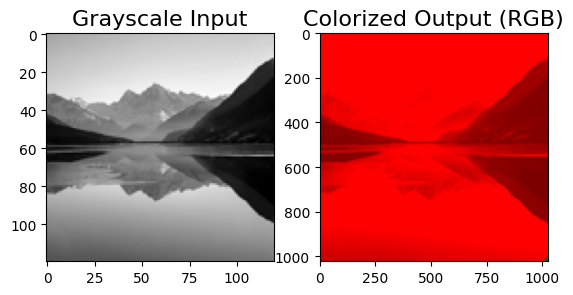

Before clipping:
Min L: 2.7450980392156863
Min a: -128.0
Min b: 128.0
After clipping:
Min L: 2.7450980392156863
Min a: -128.0
Min b: 127.0


<ipython-input-16-7bfeffb08847>:33: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 10182 negative Z values that have been clipped to zero
  rgb_image = lab2rgb(lab_image)


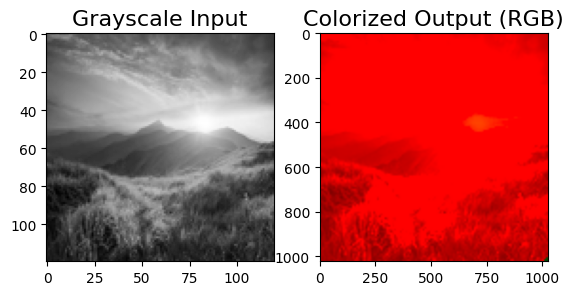

Before clipping:
Min L: 0.0
Min a: -128.0
Min b: 128.0
After clipping:
Min L: 0.0
Min a: -128.0
Min b: 127.0


<ipython-input-16-7bfeffb08847>:33: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 10907 negative Z values that have been clipped to zero
  rgb_image = lab2rgb(lab_image)


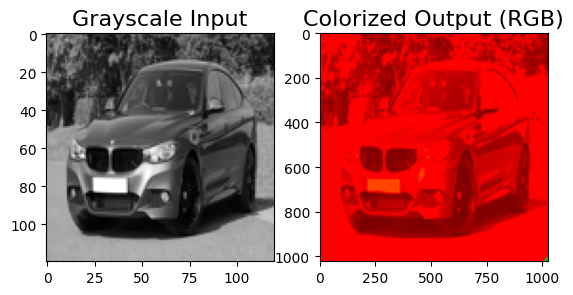

Before clipping:
Min L: 0.0
Min a: -128.0
Min b: 128.0
After clipping:
Min L: 0.0
Min a: -128.0
Min b: 127.0


<ipython-input-16-7bfeffb08847>:33: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 7607 negative Z values that have been clipped to zero
  rgb_image = lab2rgb(lab_image)


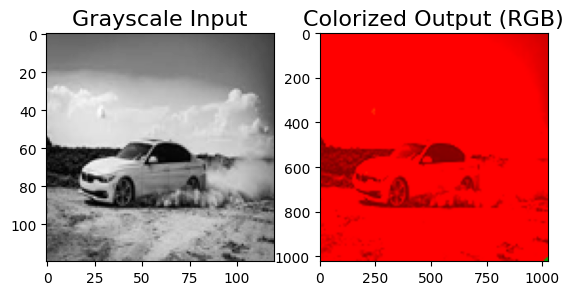

In [ ]:
for i, url in enumerate(image_urls):
    try:
        # Process the image (Grayscale L channel)
        test_image = process_image_from_url(url)

        # Generate the a and b channels as output from the generator
        ab_channels = generator(test_image).numpy()

        # Combine the input L channel with the output ab channels
        l_channel = test_image[0, :, :, 0]  # Extract L channel (grayscale input)
        lab_image = np.zeros((120, 120, 3))
        lab_image[:, :, 0] = l_channel * 100  # Scale L channel to 0-100 range
        lab_image[:, :, 1:] = ab_channels[0] * 128  # Scale a and b channels to -128 to 127 range

        print("Min L:", np.min(lab_image[..., 0]))
        print("Min a:", np.min(lab_image[..., 1]))
        print("Min b:", np.min(lab_image[..., 2]))

        # Convert the Lab image to RGB
        rgb_image = lab2rgb(lab_image)

        # Visualize the input and output
        plt.figure(figsize=(10, 10))

        # Grayscale Input
        or_image = plt.subplot(1, 3, 1)
        or_image.set_title('Grayscale Input', fontsize=16)
        plt.imshow(test_image[0].reshape((120, 120)), cmap='gray')

        # Colorized Output in RGB
        in_image = plt.subplot(1, 3, 2)
        output_image = Image.fromarray((rgb_image * 255).astype('uint8')).resize((1024, 1024))
        in_image.set_title('Colorized Output (RGB)', fontsize=16)
        plt.imshow(output_image)

        plt.show()

    except Exception as e:
        print(f"Error processing image {i + 1}: {e}")